# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../Kuptsov_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

In [4]:
df_initial

,Chr,Start,End,Strand,Length,SRR12539210_sorted.bam,SRR12539217_sorted.bam,SRR12539213_sorted.bam,SRR12539215_sorted.bam,SRR12539216_sorted.bam,SRR12539209_sorted.bam,SRR12539214_sorted.bam,SRR12539212_sorted.bam,SRR12539211_sorted.bam
Geneid,,,,,,,,,,,,,,
gene-Saur515_RS10465,NZ_JAKRSL010000012.1,194,1360,+,1167,66,352,76,373,369,48,93,114,108
gene-Saur515_RS10470,NZ_JAKRSL010000012.1,1386,2450,+,1065,57,356,89,399,351,42,99,133,96
gene-Saur515_RS10475,NZ_JAKRSL010000012.1,2460,3758,+,1299,163,646,177,689,648,99,176,233,250
gene-Saur515_RS10480,NZ_JAKRSL010000012.1,3765,5009,+,1245,259,1036,273,1129,1043,172,277,429,375
gene-Saur515_RS10485,NZ_JAKRSL010000012.1,5023,5598,+,576,88,338,102,342,356,59,104,178,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-phage515_00230,MN047438.1,146880,147011,+,132,720,2384,654,2746,2615,488,723,1240,1017
gene-phage515_00231,MN047438.1,147179,147415,+,237,1397,5112,1129,5683,5679,953,1092,1786,2092
gene-phage515_00232,MN047438.1,147495,147965,+,471,4380,14133,3725,15159,16376,3031,3612,5875,6315


In [5]:
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,Bytes,Center Name,collection_date,...,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,replicate,create_date,version,Sample Name,SRA Study
0,SRR12539209,RNA-Seq,202,967207310,PRJNA659920,SAMN15930374,Viral,493415864,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,RANDOM,GENOMIC,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E30_3,2020-08-28T08:42:00Z,1,vB_SauM-515A1_E30_3,SRP279162
1,SRR12539210,RNA-Seq,202,1049233854,PRJNA659920,SAMN15930373,Viral,543599365,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,RANDOM,GENOMIC,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E30_2,2020-08-28T08:42:00Z,1,vB_SauM-515A1_E30_2,SRP279162
2,SRR12539211,RNA-Seq,200,1828732200,PRJNA659920,SAMN15930372,Viral,818254425,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,RANDOM,GENOMIC,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E30_1,2020-08-28T08:43:00Z,1,vB_SauM-515A1_E30_1,SRP279162
3,SRR12539212,RNA-Seq,202,1356979642,PRJNA659920,SAMN15930371,Viral,685095928,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,RANDOM,GENOMIC,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E15_3,2020-08-28T08:43:00Z,1,vB_SauM-515A1_E15_3,SRP279162
4,SRR12539213,RNA-Seq,202,935231922,PRJNA659920,SAMN15930370,Viral,472835239,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,RANDOM,GENOMIC,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E15_2,2020-08-28T08:42:00Z,1,vB_SauM-515A1_E15_2,SRP279162
5,SRR12539214,RNA-Seq,202,973940576,PRJNA659920,SAMN15930369,Viral,495710078,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,RANDOM,GENOMIC,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E15_1,2020-08-28T08:42:00Z,1,vB_SauM-515A1_E15_1,SRP279162
6,SRR12539215,RNA-Seq,202,999403484,PRJNA659920,SAMN15930368,Viral,507636981,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,RANDOM,GENOMIC,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E5_3,2020-08-28T08:42:00Z,1,vB_SauM-515A1_E5_3,SRP279162
7,SRR12539216,RNA-Seq,202,997327328,PRJNA659920,SAMN15930367,Viral,510979229,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,RANDOM,GENOMIC,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E5_2,2020-08-28T08:41:00Z,1,vB_SauM-515A1_E5_2,SRP279162
8,SRR12539217,RNA-Seq,202,900479236,PRJNA659920,SAMN15930366,Viral,455429427,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,RANDOM,GENOMIC,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E5_1,2020-08-28T08:42:00Z,1,vB_SauM-515A1_E5_1,SRP279162


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'vB_SauM-515A1_E30_3': '30_R3', 'vB_SauM-515A1_E30_2': '30_R2', 'vB_SauM-515A1_E30_1': '30_R1',
              'vB_SauM-515A1_E15_3': '15_R3', 'vB_SauM-515A1_E15_2': '15_R2', 'vB_SauM-515A1_E15_1': '15_R1',
              'vB_SauM-515A1_E5_3': '5_R3',  'vB_SauM-515A1_E5_2': '5_R2',  'vB_SauM-515A1_E5_1': '5_R1'}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,Bytes,Center Name,collection_date,...,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,replicate,create_date,version,Sample Name,SRA Study
0,SRR12539209,RNA-Seq,202,967207310,PRJNA659920,SAMN15930374,Viral,493415864,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,RANDOM,GENOMIC,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E30_3,2020-08-28T08:42:00Z,1,vB_SauM-515A1_E30_3,SRP279162


In [9]:
metadataFull.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,Bytes,Center Name,collection_date,...,Organism,Platform,ReleaseDate,replicate,create_date,version,Sample Name,SRA Study,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,
SRR12539209_sorted.bam,SRR12539209,RNA-Seq,202,967207310,PRJNA659920,SAMN15930374,Viral,493415864,FEDERAL RESEARCH AND CLINICAL CENTER OF PHYSIC...,2018,...,Staphylococcus phage vB_SauM-515A1,ILLUMINA,2020-08-28T00:00:00Z,biological replicate E30_3,2020-08-28T08:42:00Z,1,vB_SauM-515A1_E30_3,SRP279162,SRR12539209_sorted.bam,30_R3


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['5_R1', '5_R2', '5_R3', '15_R1', '15_R2', '15_R3', '30_R1', '30_R2', '30_R3']]
df

SampleNames,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3
Geneid,,,,,,,,,
gene-Saur515_RS10465,352,369,373,93,76,114,108,66,48
gene-Saur515_RS10470,356,351,399,99,89,133,96,57,42
gene-Saur515_RS10475,646,648,689,176,177,233,250,163,99
gene-Saur515_RS10480,1036,1043,1129,277,273,429,375,259,172
gene-Saur515_RS10485,338,356,342,104,102,178,132,88,59
...,...,...,...,...,...,...,...,...,...
gene-phage515_00230,2384,2615,2746,723,654,1240,1017,720,488
gene-phage515_00231,5112,5679,5683,1092,1129,1786,2092,1397,953
gene-phage515_00232,14133,16376,15159,3612,3725,5875,6315,4380,3031


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/MN047438.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "MN047438.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
2812,MN047438.1,Genbank,gene,486.0,785.0,.,+,.,gene-phage515_00001,phage515_00001,Gene,protein_coding,phage515_00001,gene-phage515_00001,hypothetical protein,hypothetical protein,654.0,unknown function
2813,MN047438.1,Genbank,gene,801.0,986.0,.,+,.,gene-phage515_00002,treB,Gene,protein_coding,phage515_00002,treB,putative membrane protein,hypothetical protein,3204.0,unknown function
2814,MN047438.1,Genbank,gene,1093.0,1383.0,.,+,.,gene-phage515_00003,phage515_00003,Gene,protein_coding,phage515_00003,gene-phage515_00003,hypothetical protein,hypothetical protein,654.0,unknown function
2815,MN047438.1,Genbank,gene,1383.0,1670.0,.,+,.,gene-phage515_00004,phage515_00004,Gene,protein_coding,phage515_00004,gene-phage515_00004,hypothetical protein,hypothetical protein,654.0,unknown function
2816,MN047438.1,Genbank,gene,1670.0,1963.0,.,+,.,gene-phage515_00005,phage515_00005,Gene,protein_coding,phage515_00005,gene-phage515_00005,hypothetical protein,hypothetical protein,654.0,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,MN047438.1,Genbank,gene,146880.0,147011.0,.,+,.,gene-phage515_00230,phage515_00230,Gene,protein_coding,phage515_00230,gene-phage515_00230,hypothetical protein,hypothetical protein,3837.0,unknown function
3048,MN047438.1,Genbank,gene,147179.0,147415.0,.,+,.,gene-phage515_00231,phage515_00231,Gene,protein_coding,phage515_00231,gene-phage515_00231,hypothetical protein,hypothetical protein,3480.0,unknown function
3049,MN047438.1,Genbank,gene,147495.0,147965.0,.,+,.,gene-phage515_00232,phage515_00232,Gene,protein_coding,phage515_00232,gene-phage515_00232,hypothetical protein,hypothetical protein,2543.0,unknown function
3050,MN047438.1,Genbank,gene,147995.0,148120.0,.,+,.,gene-phage515_00233,phage515_00233,Gene,protein_coding,phage515_00233,gene-phage515_00233,hypothetical protein,hypothetical protein,7733.0,unknown function


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'MN047438.1', 'phage', 'host')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [14]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3
Geneid,,,,,,,,,
gene-Saur515_RS10265,620,702,722,182,132,242,151,143,65
gene-Saur515_RS05950,3980,4670,4622,1029,944,1586,1790,969,588
gene-Saur515_RS02420,762,767,838,372,322,497,545,557,285
gene-Saur515_RS03345,479,527,539,187,155,328,271,162,99
gene-Saur515_RS00815,184,210,221,97,68,163,176,128,82
...,...,...,...,...,...,...,...,...,...
gene-phage515_00039,2341,2696,2483,3191,2968,4380,3174,2922,1804
gene-Saur515_RS08690,72,68,84,13,17,24,13,11,4
gene-Saur515_RS07295,520,565,598,163,149,268,205,143,123


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [15]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [16]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-Saur515_RS10265,141.539129,147.569446,147.733373,46.953757,34.195208,41.498041,18.389586,26.119389,16.513280,host,gene-Saur515_RS10265
gene-Saur515_RS05950,287.069769,310.190571,298.835908,83.743080,77.066642,85.836307,68.714554,55.792269,46.908722,host,pnp
gene-Saur515_RS02420,148.411342,137.569136,146.297310,81.776076,71.018518,72.644283,56.499756,86.586163,61.417292,host,fetB
gene-Saur515_RS03345,119.664202,121.230944,120.690508,52.777603,43.905677,61.502409,36.055377,32.359767,27.444544,host,gene-Saur515_RS03345
gene-Saur515_RS00815,27.930528,29.346091,30.058170,16.647926,11.732430,18.568706,14.218444,15.522522,13.803653,host,sirC
...,...,...,...,...,...,...,...,...,...,...,...
gene-phage515_00039,907.983208,962.940523,863.284312,1395.890182,1302.372901,1274.349214,655.063741,904.304215,773.388746,phage,gene-phage515_00039
gene-Saur515_RS08690,9.024227,7.851957,9.428329,1.895302,2.464476,2.287806,0.894191,1.142211,0.619073,host,trpB
gene-Saur515_RS07295,242.953962,243.081129,250.422552,86.078315,78.951264,94.021821,51.043407,53.448009,63.712921,host,gene-Saur515_RS07295


In [17]:
# Check gene names unique
len(tpms['Symbol'].unique())

3048

Log2+1 normalization raw counts

In [18]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-Saur515_RS10265,9.278449,9.457381,9.497852,7.515700,7.055282,7.924813,7.247928,7.169925,6.044394,host,gene-Saur515_RS10265
gene-Saur515_RS05950,11.958915,12.189516,12.174614,10.008429,9.884171,10.632086,10.806550,9.921841,9.202124,host,pnp
gene-Saur515_RS02420,9.575539,9.584963,9.712527,8.543032,8.335390,8.960002,9.092757,9.124121,8.159871,host,fetB
gene-Saur515_RS03345,8.906891,9.044394,9.076816,7.554589,7.285402,8.361944,8.087463,7.348728,6.643856,host,gene-Saur515_RS03345
gene-Saur515_RS00815,7.531381,7.721099,7.794416,6.614710,6.108524,7.357552,7.467606,7.011227,6.375039,host,sirC
...,...,...,...,...,...,...,...,...,...,...,...
gene-phage515_00039,11.193525,11.397140,11.278449,11.640245,11.535761,12.097044,11.632541,11.513234,10.817783,phage,gene-phage515_00039
gene-Saur515_RS08690,6.189825,6.108524,6.409391,3.807355,4.169925,4.643856,3.807355,3.584963,2.321928,host,trpB
gene-Saur515_RS07295,9.025140,9.144658,9.226412,7.357552,7.228819,8.071462,7.686501,7.169925,6.954196,host,gene-Saur515_RS07295


Log2+1 normalization tpms

In [19]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-Saur515_RS10265,7.155214,7.214994,7.216585,5.583572,5.137307,5.409324,4.277210,4.761253,4.130377,host,gene-Saur515_RS10265
gene-Saur515_RS05950,8.170274,8.281655,8.228029,6.405024,6.286634,6.440226,6.123388,5.827623,5.582216,host,pnp
gene-Saur515_RS02420,7.223146,7.114462,7.202587,6.371142,6.170296,6.202502,5.845484,6.452631,5.963874,host,fetB
gene-Saur515_RS03345,6.914854,6.933466,6.927073,5.748934,5.488826,5.965840,5.211611,5.060037,4.830080,host,gene-Saur515_RS03345
gene-Saur515_RS00815,4.854521,4.923439,4.956901,4.141427,3.670436,4.290476,3.927749,4.046362,3.887881,host,sirC
...,...,...,...,...,...,...,...,...,...,...,...
gene-phage515_00039,9.828110,9.912800,9.755362,10.448003,10.348034,10.316677,9.357692,9.822259,9.596914,phage,gene-phage515_00039
gene-Saur515_RS08690,3.325419,3.145997,3.382436,1.533714,1.792637,1.717125,0.921582,1.099100,0.695168,host,trpB
gene-Saur515_RS07295,7.930465,7.931217,7.973970,6.444242,6.321049,6.570187,5.701643,5.766807,6.015982,host,gene-Saur515_RS07295


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [20]:
columnOrder = ['5_R1', '5_R2', '5_R3', '15_R1', '15_R2', '15_R3', '30_R1', '30_R2', '30_R3']

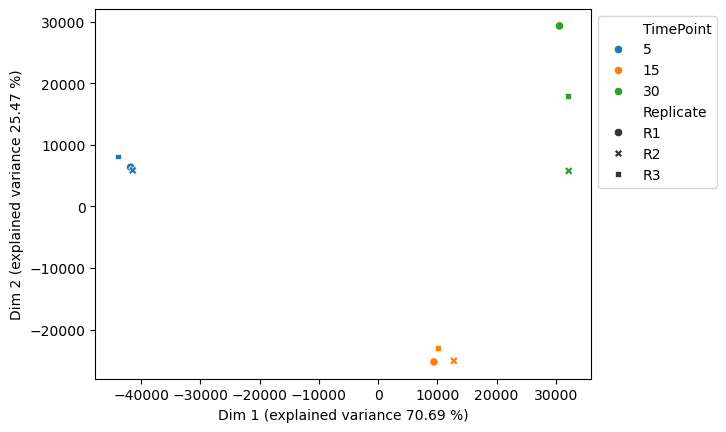

In [21]:
txPCA(tpms[columnOrder])

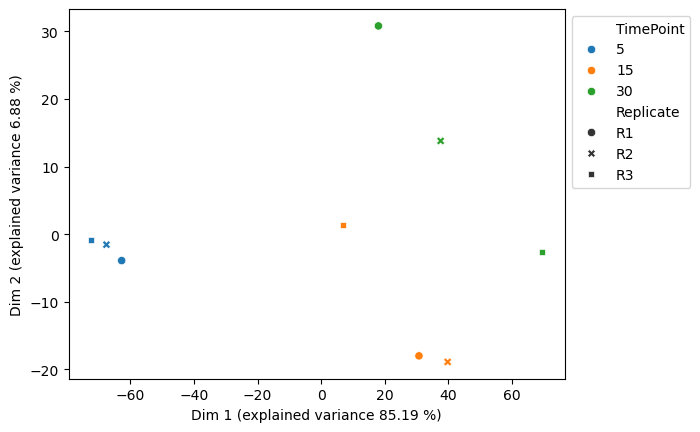

In [22]:
txPCA(logs[columnOrder])

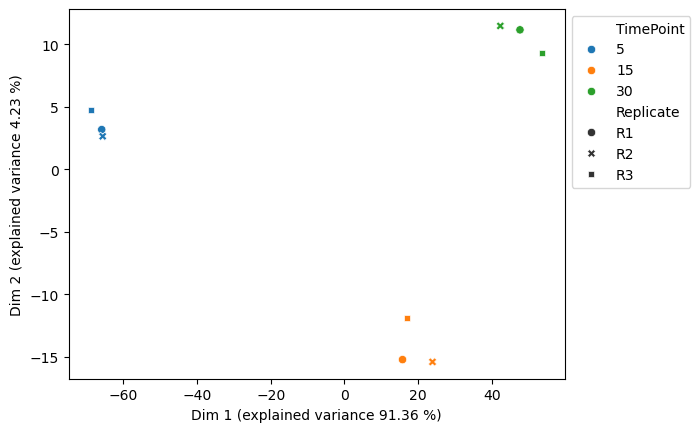

In [23]:
txPCA(logTPMs[columnOrder])

In [24]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

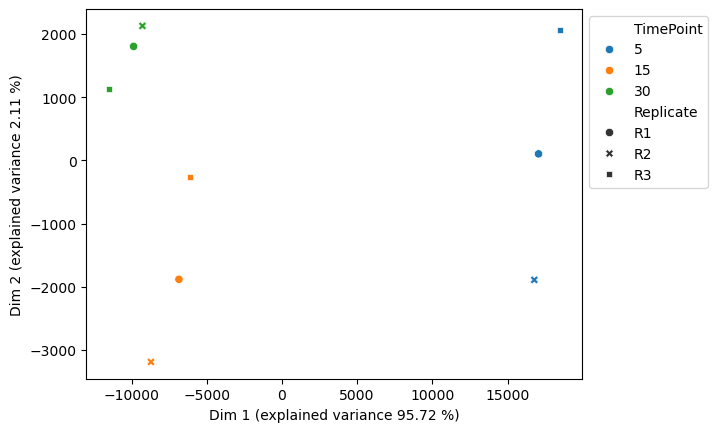

In [25]:
txPCA(tpmHost[columnOrder])

tpmPhage

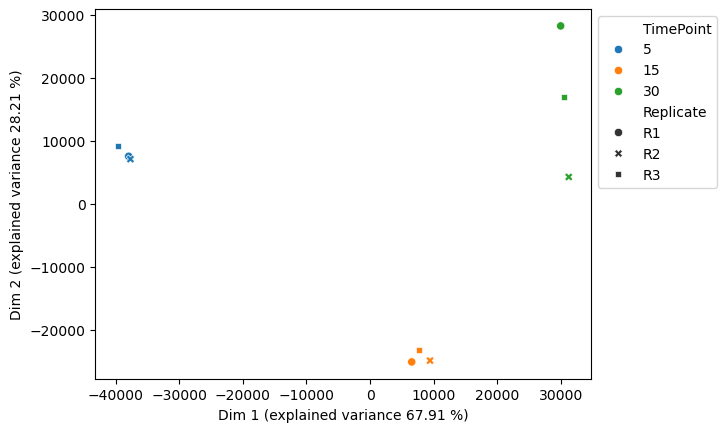

In [26]:
txPCA(tpmPhage[columnOrder])

logTPM Host

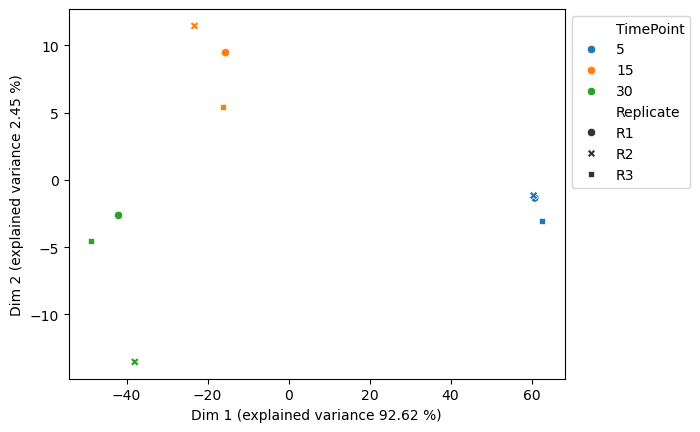

In [27]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

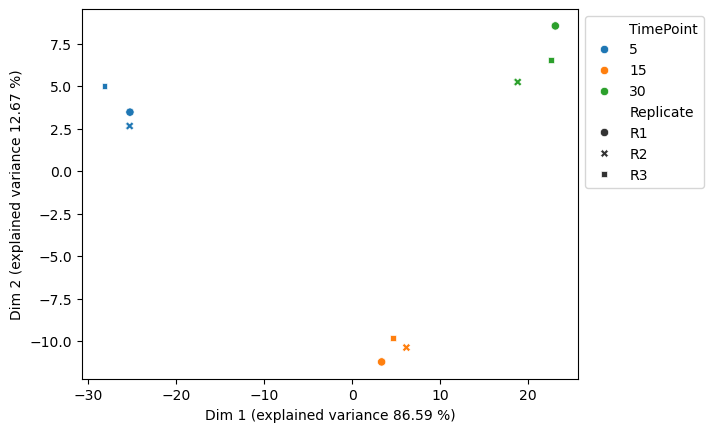

In [28]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Replicates seem to be fine (not perfect, but no clear outliers detectable)

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [29]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['5', '15', '30']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,5,15,30,Entity,Symbol
Geneid,,,,,
gene-Saur515_RS10265,145.613983,40.882335,20.340751,host,gene-Saur515_RS10265
gene-Saur515_RS05950,298.698749,82.215343,57.138515,host,pnp
gene-Saur515_RS02420,144.092596,75.146293,68.167737,host,fetB
gene-Saur515_RS03345,120.528551,52.728563,31.953230,host,gene-Saur515_RS03345
gene-Saur515_RS00815,29.111596,15.649688,14.514873,host,sirC
...,...,...,...,...,...
gene-phage515_00039,911.402681,1324.204099,777.585567,phage,gene-phage515_00039
gene-Saur515_RS08690,8.768171,2.215862,0.885158,host,trpB
gene-Saur515_RS07295,245.485881,86.350467,56.068112,host,gene-Saur515_RS07295


In [30]:
TPMsds = TPMsds[['5', '15', '30']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,5,15,30,Entity,Symbol
Geneid,,,,,
gene-Saur515_RS10265,2.882134,5.226819,4.157292,host,gene-Saur515_RS10265
gene-Saur515_RS05950,9.439526,3.739629,8.952946,host,pnp
gene-Saur515_RS02420,4.692826,4.734716,13.177616,host,fetB
gene-Saur515_RS03345,0.649791,7.183920,3.527092,host,gene-Saur515_RS03345
gene-Saur515_RS00815,0.884291,2.878776,0.732362,host,sirC
...,...,...,...,...,...
gene-phage515_00039,40.756265,51.964748,101.795263,phage,gene-phage515_00039
gene-Saur515_RS08690,0.668536,0.237868,0.213666,host,trpB
gene-Saur515_RS07295,3.491139,6.155538,5.494109,host,gene-Saur515_RS07295


In [31]:
propExp = proportionalExp(TPMmeans[['5','15','30']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,5,15,30,Entity,Symbol
Geneid,,,,,
gene-Saur515_RS10265,1.000000,0.280758,0.139690,host,gene-Saur515_RS10265
gene-Saur515_RS05950,1.000000,0.275245,0.191291,host,pnp
gene-Saur515_RS02420,1.000000,0.521514,0.473083,host,fetB
gene-Saur515_RS03345,1.000000,0.437478,0.265109,host,gene-Saur515_RS03345
gene-Saur515_RS00815,1.000000,0.537576,0.498594,host,sirC
...,...,...,...,...,...
gene-phage515_00039,0.688265,1.000000,0.587210,phage,gene-phage515_00039
gene-Saur515_RS08690,1.000000,0.252717,0.100951,host,trpB
gene-Saur515_RS07295,1.000000,0.351753,0.228396,host,gene-Saur515_RS07295


## 5. Phage gene classification

In [32]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [33]:
# Export fractional expressions with T=0.6 + Host/Phage Annotation for Orthofinder Analysis
# t = classLabelThreshold(propExp)
# t = t[t["Entity"] == "phage"]
# t["Host"] = "Staphylococcus_aureus_strain_SA515"
# t["Phage"] = "Staphylococcus_phage_vB_SauM-515A1"
# t.to_csv("/ceph/ibmi/studenten/waffen/Cross_Analysis/Orthofinder_Clustering/Fractional_Expressions/T060/Kuptsov_fractional_expression_T=0.6.tsv", sep="\t")

In [34]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [35]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [36]:
TPMmeans

,5,15,30,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,
gene-Saur515_RS10265,145.613983,40.882335,20.340751,host,gene-Saur515_RS10265,None,None
gene-Saur515_RS05950,298.698749,82.215343,57.138515,host,pnp,None,None
gene-Saur515_RS02420,144.092596,75.146293,68.167737,host,fetB,None,None
gene-Saur515_RS03345,120.528551,52.728563,31.953230,host,gene-Saur515_RS03345,None,None
gene-Saur515_RS00815,29.111596,15.649688,14.514873,host,sirC,None,None
...,...,...,...,...,...,...,...
gene-phage515_00039,911.402681,1324.204099,777.585567,phage,gene-phage515_00039,early,middle
gene-Saur515_RS08690,8.768171,2.215862,0.885158,host,trpB,None,None
gene-Saur515_RS07295,245.485881,86.350467,56.068112,host,gene-Saur515_RS07295,None,None


Add classes to other dfs.

In [37]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] != 'MN047438.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'MN047438.1']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [38]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [39]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,
gene-Saur515_RS10265,141.539129,147.569446,147.733373,46.953757,34.195208,41.498041,18.389586,26.119389,16.513280,host,gene-Saur515_RS10265,None,None,43.903776
gene-Saur515_RS05950,287.069769,310.190571,298.835908,83.743080,77.066642,85.836307,68.714554,55.792269,46.908722,host,pnp,None,None,80.960590
gene-Saur515_RS02420,148.411342,137.569136,146.297310,81.776076,71.018518,72.644283,56.499756,86.586163,61.417292,host,fetB,None,None,13.014252
gene-Saur515_RS03345,119.664202,121.230944,120.690508,52.777603,43.905677,61.502409,36.055377,32.359767,27.444544,host,gene-Saur515_RS03345,None,None,21.226114
gene-Saur515_RS00815,27.930528,29.346091,30.058170,16.647926,11.732430,18.568706,14.218444,15.522522,13.803653,host,sirC,None,None,2.386525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-phage515_00039,907.983208,962.940523,863.284312,1395.890182,1302.372901,1274.349214,655.063741,904.304215,773.388746,phage,gene-phage515_00039,early,middle,58.772097
gene-Saur515_RS08690,9.024227,7.851957,9.428329,1.895302,2.464476,2.287806,0.894191,1.142211,0.619073,host,trpB,None,None,3.046906
gene-Saur515_RS07295,242.953962,243.081129,250.422552,86.078315,78.951264,94.021821,51.043407,53.448009,63.712921,host,gene-Saur515_RS07295,None,None,53.587924


In [40]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [41]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]

In [42]:
# Full TPM table
tpms.to_csv('Kuptsov_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Kuptsov_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Kuptsov_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Kuptsov_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Kuptsov_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Kuptsov_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Kuptsov_phage_gff3.tsv', sep='\t')